# Objekterkennung mit Icevision

Für die Objekterkennung nutzen wir das Framework Icevision, da es sehr gut zusammen mit Fastai funktioniert und auch sehr simple für die Verwendung ist.

Für die Trainingsdaten können bei Icevision verschiedene Arten verwendet werden. Eine Art davon ist CoCo, was perfekt mit dem Labelingtool zusammen passt.


## Imports

Zu begnn wieder die Notwendigen imports.

In [1]:
# check cuda version, wenn nicht 11.6 muss unten eventuell etwas angepasst werden!
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [2]:
# dies braucht eine Weile. Sollten Fehler auftauchen, bitte nochmals ausführen
!pip install icevision[all] --quiet --upgrade
!pip install "sahi<0.9.0" --quiet
!pip install -U openmim mmdet --quiet
!mim install mmcv-full --quiet

/opt/conda/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
%matplotlib inline

In [4]:
from icevision.all import *
from icevision.models.checkpoint import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

import os

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/jovyan/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


## Parser

Als erstes muss der Pfad definiert werden, wo die exportieren CoCo-Daten gespeichert worden sind.

In [5]:
path = Path('icevision_BB_CoCo/'); path

Path('icevision_BB_CoCo')

Dann muss der Parser definiert werden. 
Das CoCo-Format besteht aus einem Ordner mit allen Bildern und einem JSON-File. In dem JSON-File werden alle definierten Labels, eine Liste von allen Bildern und die Koordinaten Punkte für alle Bounding Boxes pro Bild gespeichert. Damit Icevision dieses Format versteht muss ein CoCo-Parser erstellt werden.

In [6]:
parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'result.json',
    img_dir = path
)

### Parsing

Mit dem erstellten parser können die Trainingsdaten nun geparst werden.

In [7]:
train_records, valid_records = parser.parse()

  0%|          | 0/100 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/20 [00:00<?, ?it/s]

Beim Parsen werden die Inputsdaten geteilt in Trainingsdaten und Validierungsdaten. Die Trainingsdaten sind dafür zuständig ein Modell zu trainieren und unserem Use-Case anzupassen,
während die Validierungsdaten genutzt werden, um zu überprüfen, wie genau das Modell bereits angepasst wurde.

Um zu sehen, welche Labels definiert wurden kann man die `class_map` ausgeben

In [8]:
parser.class_map

<ClassMap: {'background': 0, 'Cone': 1, 'Person': 2}>

In [9]:
len(train_records)

16

Falls man will, kann man sich die Daten auch anzeigen lassen

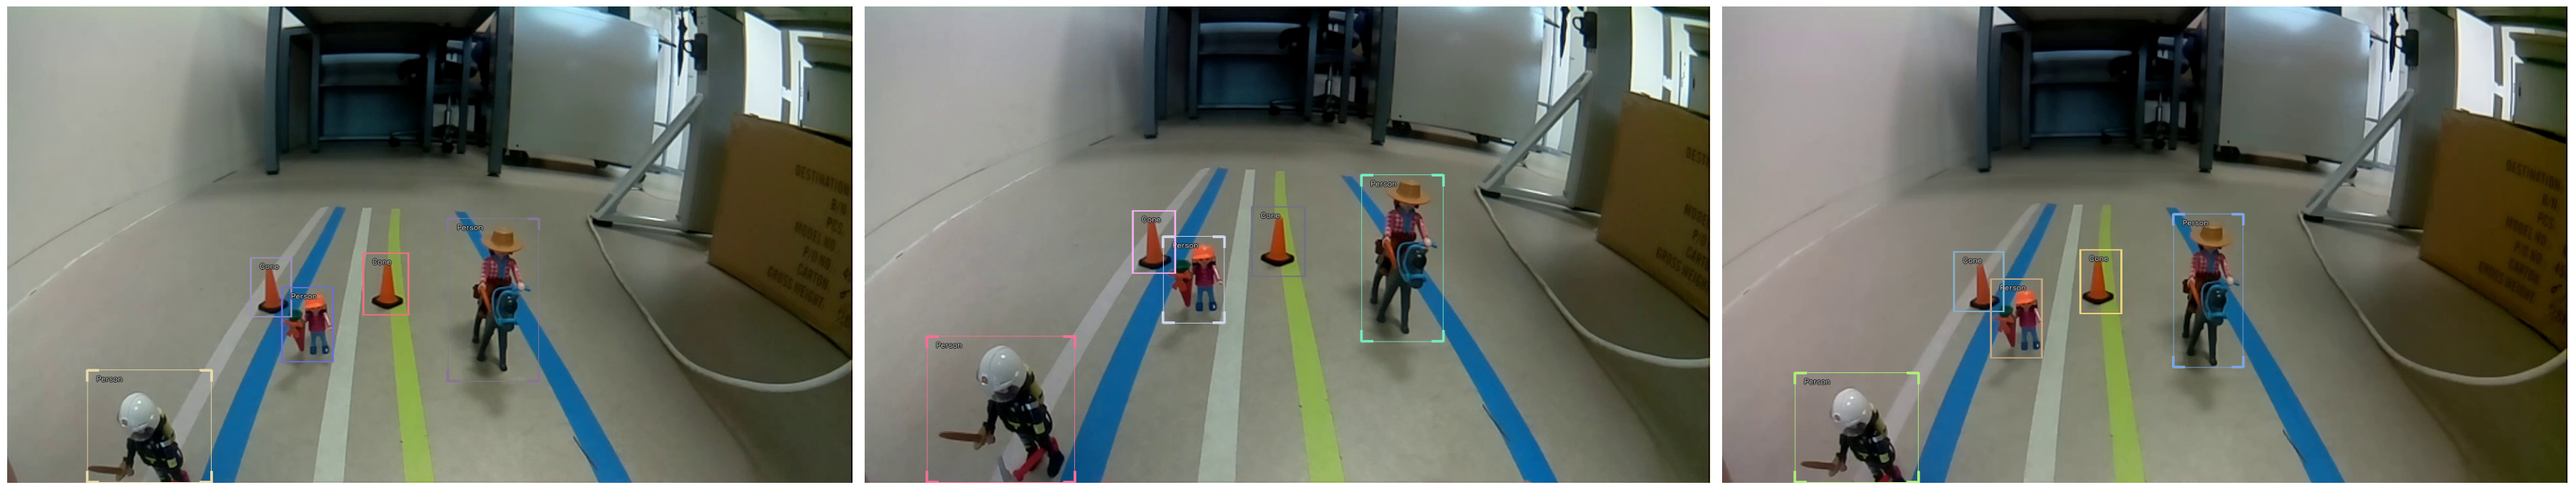

In [10]:
show_records(train_records[0:3], ncols=3, class_map=class_map, show=True)

## Datasets

Für ein robustes Training und präziseres Modell sind Bilderveränderungen und -Transformationen notwendig. Das Bedeutet, dass man für das Training die Bilder auf verschiedene Arten anpasst, mit z.B. Rotationen, Spiegelungen, Ausschneiden etc. Die standard Transformierungen haben einen Zufallswert. Das bedeutet, dass im Trainings z.B. die Rotation um einen Zufälligen Winkel geschiet. So kriegt das Modell alle Bilder in vielen verschiedenen Versionen.

Dafür liefert Icevision die `Albumentation`-Bibliothek mit.

Die Transformationen werden jeweils nur auf den Trainingsdaten (`train_records`) ausgeführt, während die Validierungsdaten (`valid_records`) nur skaliert werden.

**Wichtig:** die Bildergrösse muss eine Zahl sein, die durch 128 Teilbar ist. Das ist eine Anforderung von EfficientDet!

In [11]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

Aus diesen transformierten Bildern können nun die Datasets erstellt werden. Ein Dataset beinhaltet sowohl die Originaldaten, wie auch die transformierten.

In [12]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

#### Transformierten Daten anschauen

Für die Interessierten ist es möglich diese Transformierten Daten auch anzuschauen

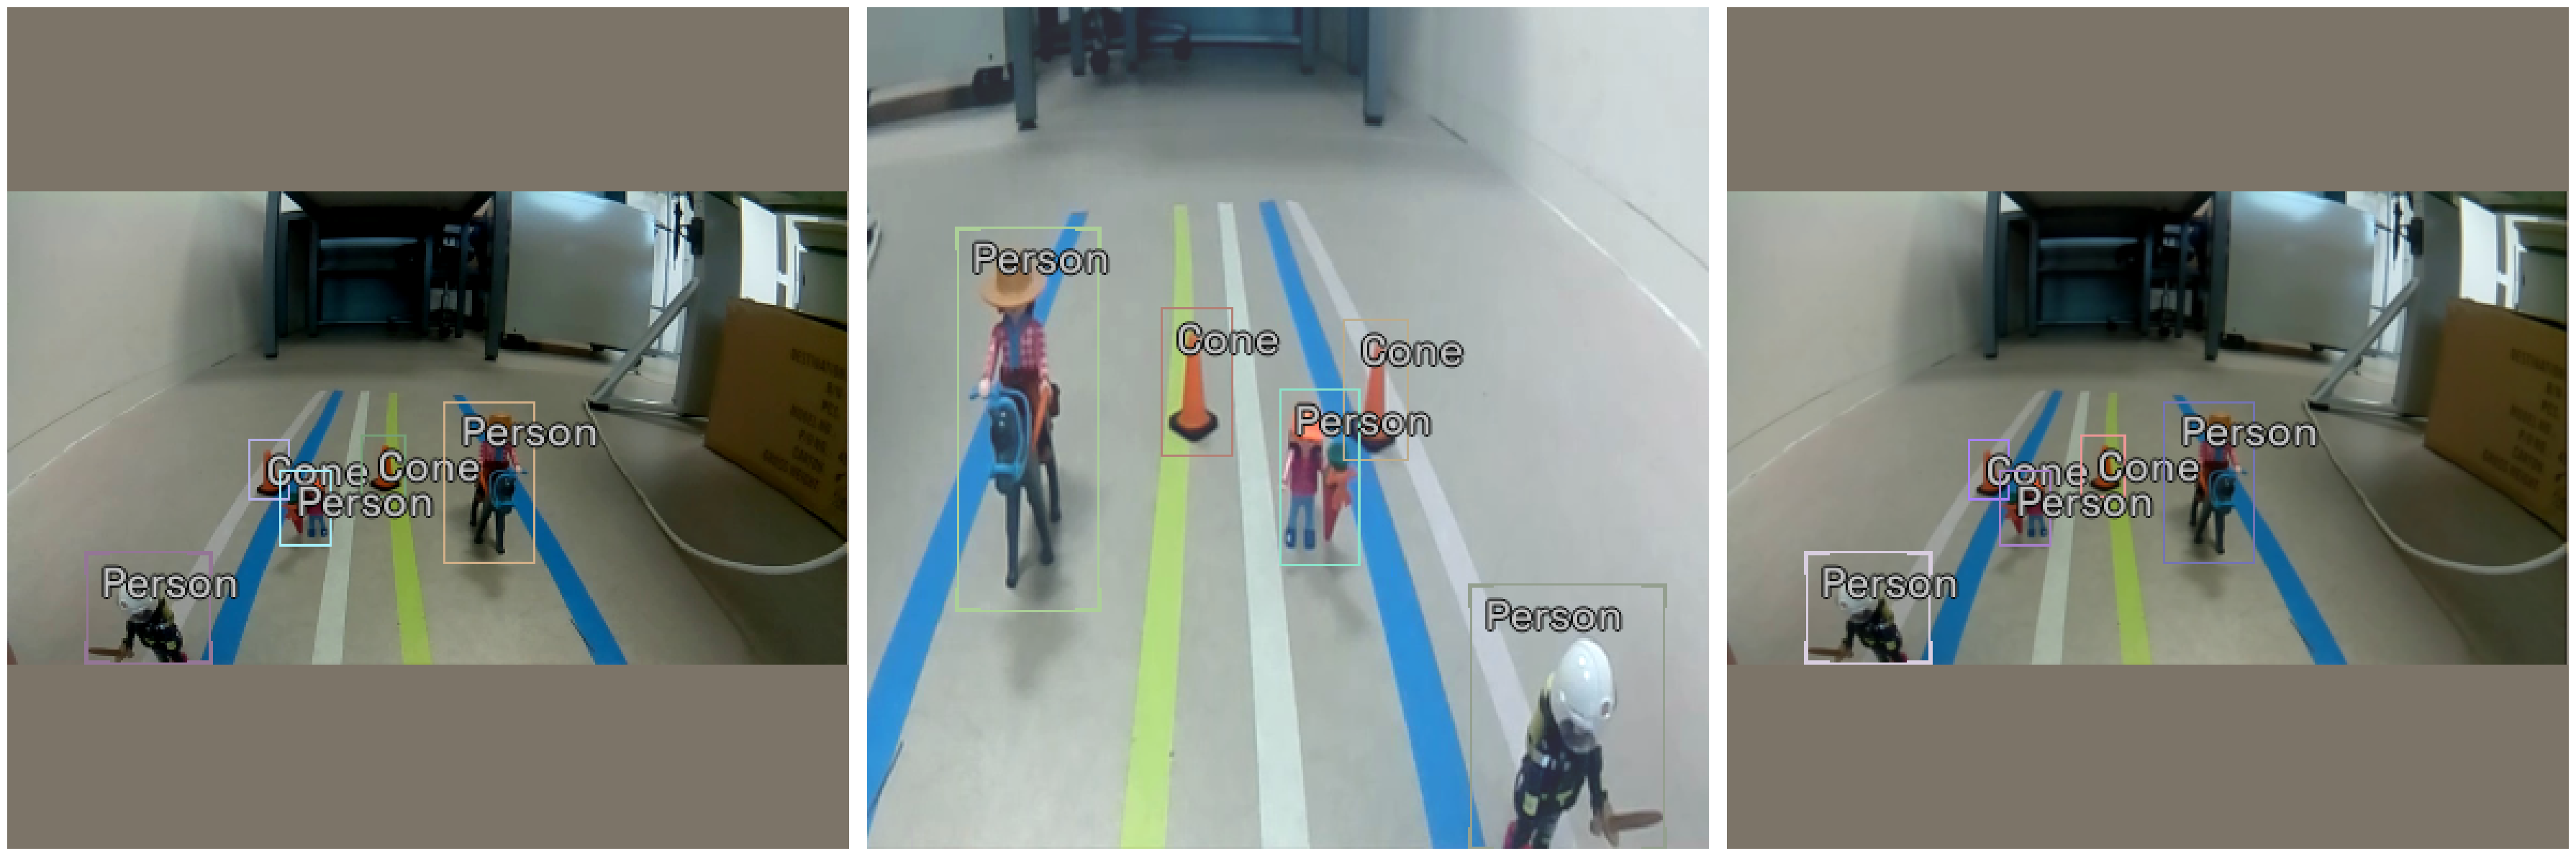

In [13]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Auswahl der Bibliothek

Als nächstes muss ein Modell und ein Backbone ausgewählt werden mit dem die Daten trainiert und validiert werden. Icevision stellt dafür mehrere Optionen zu Verfügung. Auch hier ist die Wahl des Modells wieder sehr entscheident.

Ein grösseres Modell dauert länger beim trainieren und Vorhersagen eines Bildes, jedoch ist es oft genauer. Während kleinere Modelle schneller sind, jedoch oft ungenauer.

Gewisse Modelle brauchen noch zusätzliche Argumente, damit sie initialisiert werden können, wie z.B. Yolov5 braucht noch die `image_size`

In [14]:
extra_args = {}
model_type = models.torchvision.retinanet
backbone = model_type.backbones.resnet50_fpn

Aus diesen Daten kann das notwendige Modell erstellt werden

In [15]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Data Loader

Die Aufgabe eines Data Loaders ist es die Bilder der Datasets in verschiedene Batches in dem bestimmten Modelformat zu unterteilen. Da die Data Loaders abhängig vom gewählten Modell ist, ist dieser Schritt vom erstellen der Datasets getrennt. 

In [16]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

### Metrics

Fastai sammelt Metriken um den Forschritt während des Trainings zu überprüfen.

In [17]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

Nun da alles vorbereitet ist kann man mit dem Training beginnen. Icevision ist ein agnostisches Framework. Das heisst, dass man es mit anderen Deep Learning Engines verwenden kann. Wir verwenden hier wieder Fastai. 

Wie schon beim letzten mal muss für das Trainieren ein learner erstellt werden. Dieser besteht aus den `Data Loaders`, dem `Modell` und den `Metriken`

In [18]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

### Lernrate

Der nächste Schritt ist das berechnen der Lernrate. 

Diese stellt sicher, dass das Modell nicht zu schnell oder zu langsam trainiert wird. Falls beim trainieren über mehrere Epochen später der `Validation loss` und der `Trainings loss` grosse sprünge macht ist der Grund oft eine schlechte Lernrate. Eine Lernrate ist oft eine kleine Zahl.

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=0.00013182566908653826)

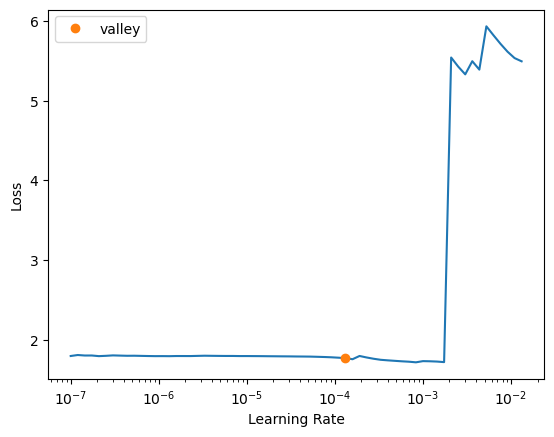

In [19]:
learn.lr_find()

In [20]:
lr = 0.00010964782268274575

Der nächste Schritt ist das Training über mehrere Epochen

In [21]:
learn.fine_tune(25, lr, freeze_epochs=1)

Der erste Schritt vom review des Modells ist es das Resultat des Validierungsset anzuschauen. Dafür kann die `show_results` Funktion benutzt werden.

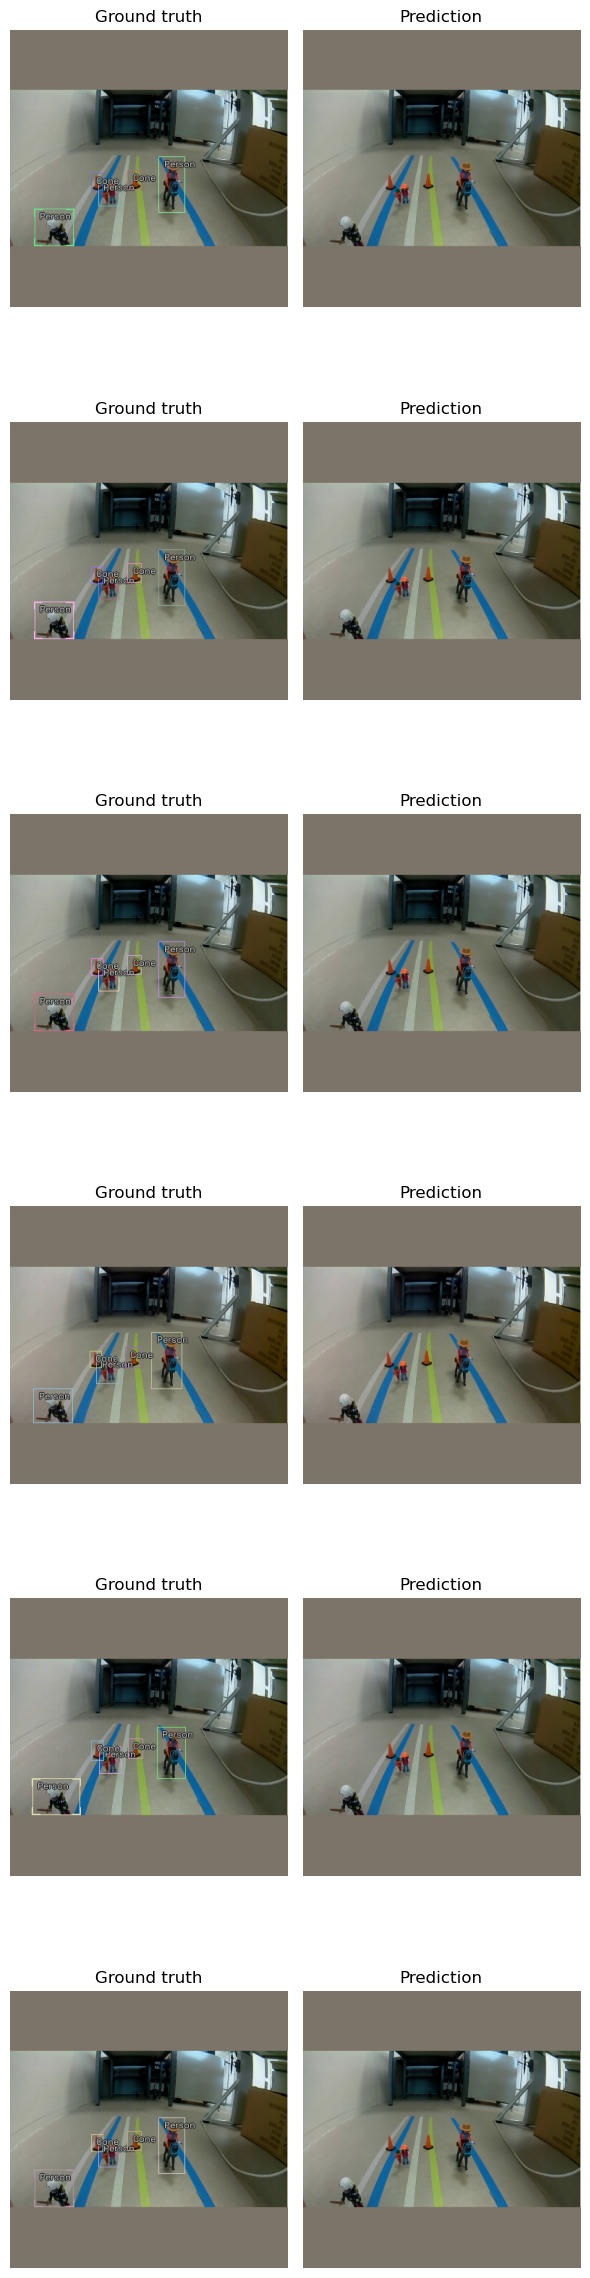

In [22]:
model_type.show_results(model, valid_ds)

## Predict (Vorhersagen)

Nun haben wir ein trainiertes Modell, dass wir für Objekt erkennung nutzen können. Der nächste Schritt ist es das Modell anzuwenden bzw. vorhersagen über Bilder zu machen, welche nicht im Trainingsset drinn waren. Dafür kann man ein Inference Data Loader `infer_dl` erstellen und diesen an `predict_dl` übergeben, um sich mit `show_preds` die Resultate anzeigen zu lassen.

Eine Vorhersage (Prediction) gibt einen Dictionary mit folgenden Schlüssel zurück: `scores`, `labels`, `bboxes` und evt `masks`

Es ist auch möglich der `predict`-Funktion einen `detection_threshhold` mitzugeben. Um sicherzustellen, wie viel Prozent sich das Modell sicher sein muss ein Objekt richtig erkannt zu haben, bevor das Modell die Daten zurückgibt.

In [23]:
img_size = 384

In [24]:
path_to_image_folder = "./icevision_BB_CoCo/images"
img_files = get_image_files(path_to_image_folder)

In [25]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])
class_map = parser.class_map

### Einzelbilder

Für die Vorhersage von Einzelbildern kann die Funktion `end2end_detect()` genutzt werden

In [26]:
img_size = 384
img = PIL.Image.open(img_files[0])

In [27]:
pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

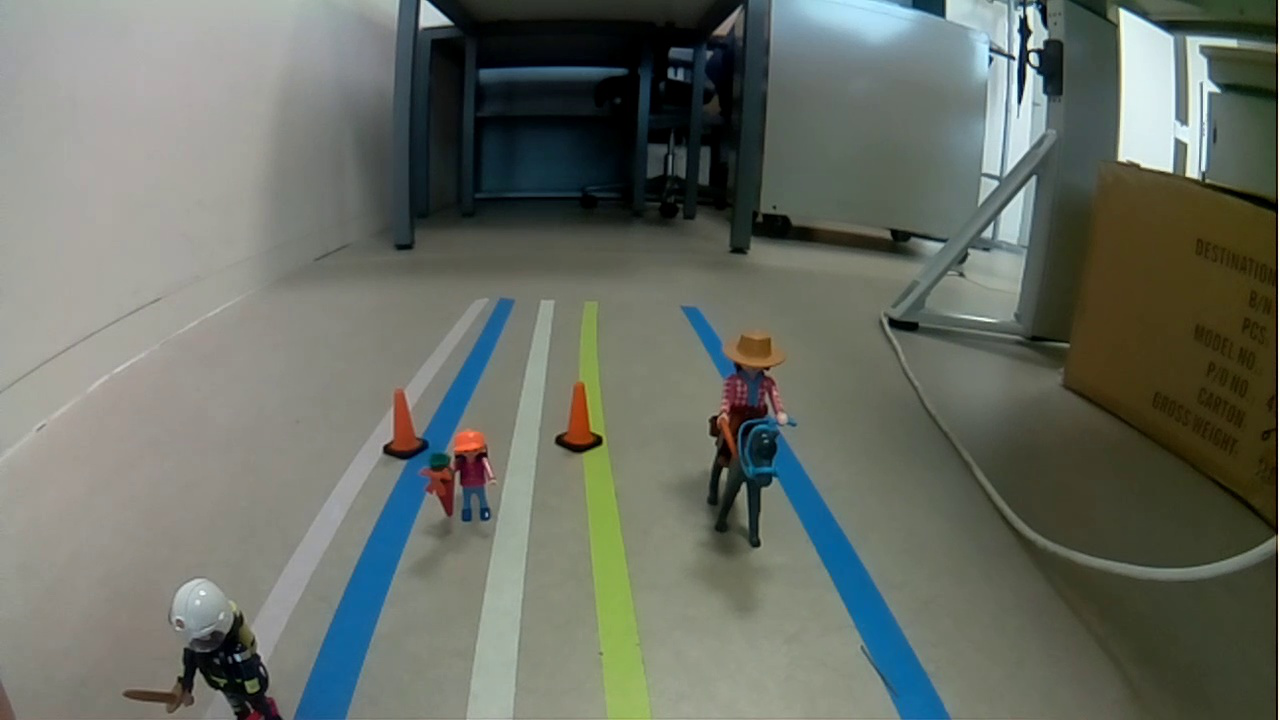

In [28]:
pred_dict['img']

### Mehrere Bilder

Es ist auch möglich Bilder in Bacthes vorherzusagen.

In [29]:
# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True, detection_threshold=0.33)

  0%|          | 0/5 [00:00<?, ?it/s]

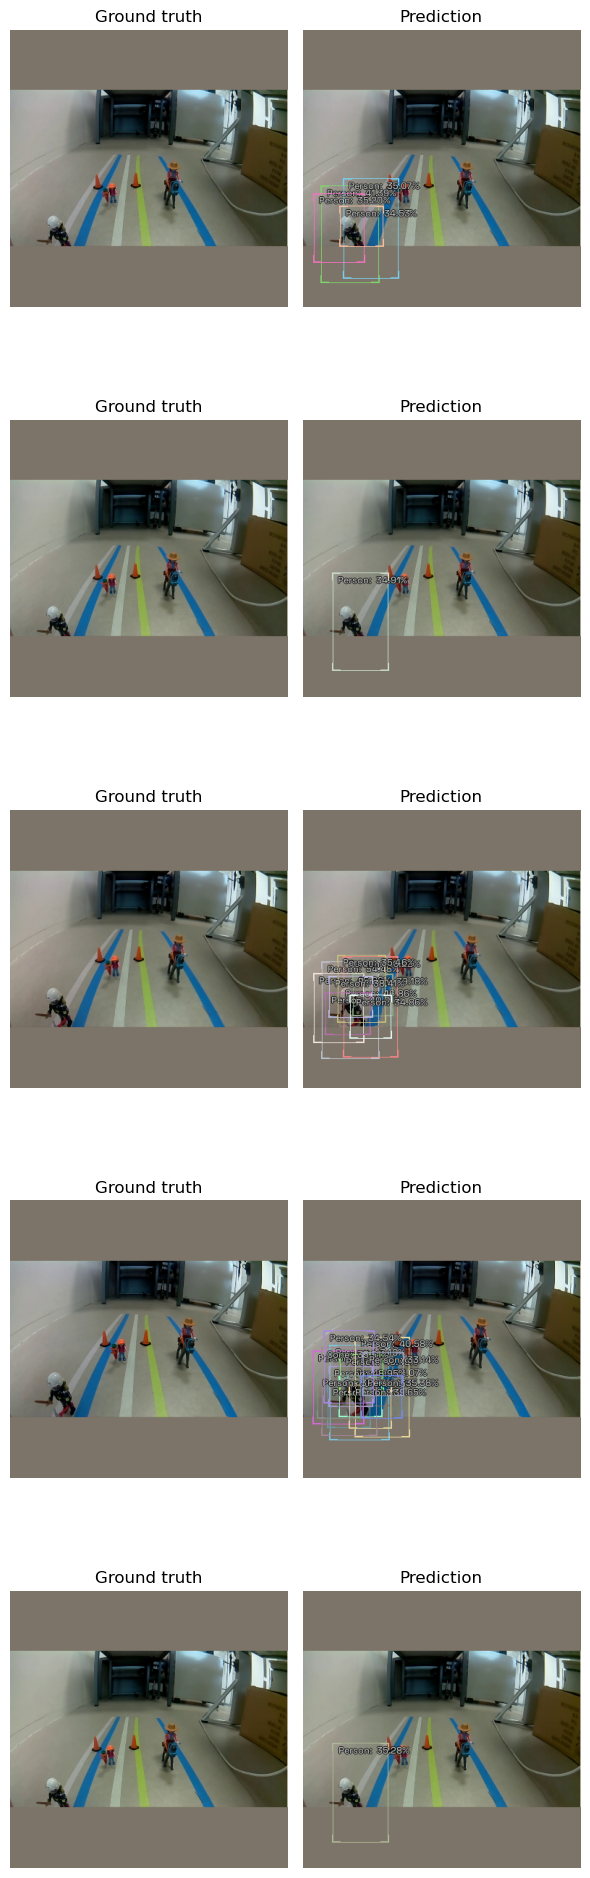

In [30]:
show_preds(preds=preds[0:5])

## Exportieren des Modells

Das Modell kan exportiert werden in das `.pth`-Format. Für das exportieren kann von icevision die Funktion `save_icevision_checkpoint` genutzt werden. Bei dieser müssen die Metadaten des Modells angegeben werden.

In [31]:
checkpoint_path = 'model.pth'
checkpoint_path

'model.pth'

In [32]:
img_size = 384
class_map = parser.class_map
save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  class_map.get_classes(), 
                        img_size=img_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.12.0'})

## Laden eines Modells

Wenn ein Modell mit den Metadaten gespeichert wurde kann es auch ganz einfach mit `model_from_checkpoint` geladen werden

In [33]:
checkpoint_and_model = model_from_checkpoint(checkpoint_path)

load checkpoint from local path: model.pth


2022-11-11 09:26:33,126 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-11-11 09:26:33,127 - mmcv - INFO - load model from: torchvision://resnet50
2022-11-11 09:26:33,128 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
2022-11-11 09:26:33,194 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-11-11 09:26:33,212 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-11-11 09:26:33,245 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'retina_cls', 'std': 0.01, 'bias_prob': 0.01}}
2022-11-11 09:26:33,269 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-11-11 09:26:33,270 - mmcv - INFO

The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.classification_head.conv.0.weight, head.classification_head.conv.0.bias, head.classification_head.conv.2.weight, head.classification_head.conv.2.bias, head.classification_head.conv.4.weight, head.classification_head.conv.4.bias, head.classification_head.conv.6.weight, head.classification_head.conv.6.bias, head.classification_head.cls_logits.weight, head.classification_head.cls_logits.bias, head.regression_head.conv.0.weight, head.regression_head.conv.0.bias, head.regression_head.conv.2.weight, head.regression_head.conv.2.bias, head.regression_head.conv.4.weight, head.regression_head.conv.4.bias, head.regression_head.conv.6.weight, head.regression_head.conv.6.bias, head.regression_head.bbox_reg.weight, head.regression_head.bbox_reg.bias, backbone.body.conv1.weight, backbone.body.bn1.weight, backbone.body.bn1.bias, backbone.body.bn1.running_mean, backbone.body.bn1.running_var, backbone.body.la

Sobald alle Gewichte geladen sind kann man einfach au alles zugreifen.

In [34]:
model = checkpoint_and_model["model"]
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]

### Testen des geladenen Modells

Testen wir noch, ob das Modell auch wirklich geladen wurde. Dazu einfach wie oben beschrieben die gewünschten Bilder laden und die neu geladenen Daten einsetzten

In [35]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

In [36]:
# see above
# path_to_image_folder = "./icevision_BB_CoCo/images"
img_files = get_image_files(path_to_image_folder)

In [37]:
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

In [38]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/5 [00:00<?, ?it/s]

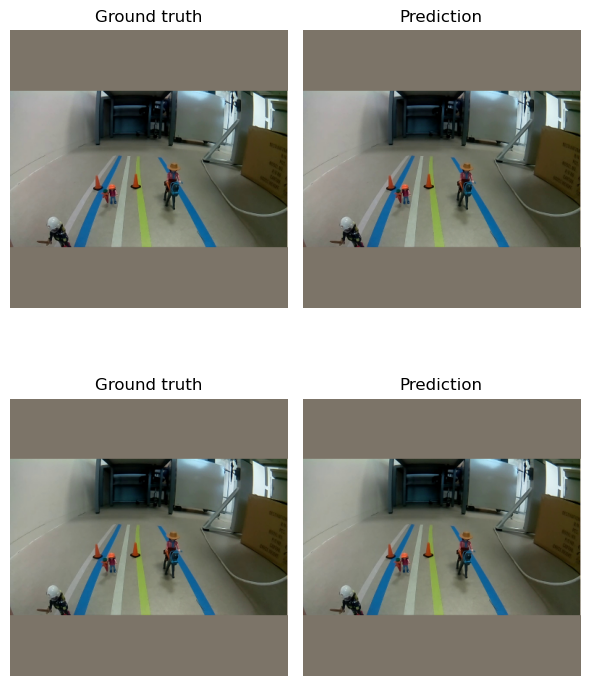

In [39]:
show_preds(preds=preds[0:2])